In [108]:
using Pkg
Pkg.activate("C:/Users/lisah/Documents/Repos/ma-code")
include("c:/Users/lisah/Documents/Repos/ma-code/src/src.jl")
using Distributions, Plots, KernelDensity, DataFrames

  Activating project at `C:\Users\lisah\Documents\Repos\ma-code`


In [109]:
n = 100
t_pt_sample_dens = 30;

In [110]:
# don't change
t_fixed = true
t_end = 100.0
#M = Int(t_end * 10) # plot M points
#t_pt_sample_dens = t_pt_sample_dens  * 10; Q: warum hatte ich das gemacht, ist irgendwie falsch? bzw eher unnötig?

100.0

### Tools

In [111]:
# copied from sa on prior/post notebook
"""
    function plot_prob_traj(times::Vector{Float64}, n_traj_sampled::Vector{Any}, w_traj_sampled::Vector{Any}, data_true::DataFrame, prm::String)

Plot probabilistic trajectories of model simulations. Black line indicates true, noiseless solution.

# Args:
    - `times::Vector{Float64}"`: considered time points of solution
    - `n_traj_sampled::Vector{Any}`: each item is vector of one sampled trajectory of n
    - `w_traj_sampled::Vector{Any}`: each item is vector of one sampled trajectory of w
    - `data_true::DataFrame`: output of sol_klausmeier for true parameter values (not noisy!)
    - `prm::String`: name of the parameter sampled to create trajectory samples
"""
function plot_prob_traj(times::Vector{Float64}, n_traj_sampled::Vector{Any}, w_traj_sampled::Vector{Any}, data_true::DataFrame, prm::String)
    n_mean = mean(n_traj_sampled, dims=1)
    w_mean = mean(w_traj_sampled, dims=1)

    n = length(n_traj_sampled)

    plot_traj = plot(times, n_mean, label="mean n", lw=2, color=:blue, legend=:bottomright, title="Model outputs under variation of $prm")
    plot!(times, w_mean, label="mean w", lw=2, color=:orange)
    for i in range(1, n)
        plot!(times,n_traj_sampled[i], color=:blue, alpha=0.05, label="")
        plot!(times,w_traj_sampled[i], color=:orange, alpha=0.05,label="")
    end
    plot!(times, data_true[!,"n"], lw=2, color=:black, label="",linestyle=:dash)
    plot!(times, data_true[!,"w"], lw=2, color=:black, label="", linestyle=:dash)
    return plot_traj
end

plot_prob_traj

In [112]:
"""
    function plot_sample_dens_t(t_pt_sample_dens::Int64, traj_sampled::Vector{Any}, traj_t_true::Float64, traj_name::String)

Plots the sample density of the trajectories at specified time point. Vertical lines indicate true values of noiseless solution at t_pt_sample_dens.

# Args:
    - `t_pt_sample_dens::Int64`: time point at which sample density is computed
    - `traj_sampled::Vector{Any}`: each item is vector of one sampled trajectory
    - `traj_t_true::Float64`: true value at time point of trajectory (not noisy!)
    - `traj_name::String`: name of the trajectory considered in samples
"""        
function plot_sample_dens_t(t_pt_sample_dens::Int64, traj_sampled::Vector{Any}, traj_t_true::Float64, traj_name::String)
    traj_t_sam = [s[t_pt_sample_dens] for s in traj_sampled]
    traj_t_dens = kde(traj_t_sam)
    plot_dens = plot(traj_t_dens.x, traj_t_dens.density, color=:blue, lw=2, ylabel="$traj_name", label="", title="Sample densities under variation of a,m")
    vline!([traj_t_true], color=:black, linestyle=:dash, label="")
    return plot_dens
end

plot_sample_dens_t

In [113]:
"""
    function sample_am_traj(dist::Distribution, n::Int64; w0::Float64=0.95, n0::Float64=1.5, M::Int64=100, noise::Float64=0.0, t_fixed::Bool=true, t_end::Float64=100.0, t_step::Float64=1.0)

        sample parameters from given distribution and simulate the trajectories they create.

# Args
    - 'density::Distribution': the distribution from which to sample a,m parameters
    - 'n::Int64': sample size

# Returns
    - 'Vector': contains samples of n trajectory
    - 'Vector': contains samples of w trajectory
"""
function sample_am_traj(dist::Distribution, n::Int64; w0::Float64=0.95, n0::Float64=1.5, M::Int64=100, noise::Float64=0.0, t_fixed::Bool=true, t_end::Float64=100.0, t_step::Float64=1.0)
    # sample parameters from given density
    samples = rand(dist, n)

    # store for plotting
    n_traj_sampled = []
    w_traj_sampled = []

    # for each sample solve klausmeier model
    for i in 1:size(samples,2)
        s = samples[:,i]
        hprm = Src.Hyperprm(w0,n0,s[1],s[2],M,noise)
        sol = Src.sol_klausmeier(hprm, t_fixed=t_fixed, t_end=t_end)
        sol = Src.randomize_data!(sol, hprm.noise)
        push!(n_traj_sampled, sol[!,"n"])
        push!(w_traj_sampled, sol[!,"w"])
    end
    return n_traj_sampled, w_traj_sampled
end

sample_am_traj

### LEFT

In [114]:
# create true data trajectories
w0 = 0.95
n0 = 1.5
a = 0.3
m = 0.45
M = 100
noise = 0.0

hprm = Src.Hyperprm(w0,n0,a,m,M,noise)
data_true = Src.sol_klausmeier(hprm, t_fixed=t_fixed, t_end=t_end) # non-noisy data
times = data_true[!,"time"]

# true values at t_pt_sample_dens
n_t_true, w_t_true = data_true[!,"n"][t_pt_sample_dens], data_true[!,"w"][t_pt_sample_dens];

#### noise 0.01

For now: manually extract MLEs for a, m from inverse uq notebook

In [115]:
mle = [0.3011294959350269, 0.4521741218077887]
cov = [0.000105457  3.47582e-5; 3.47582e-5   0.000287127]
posterior = MvNormal(mle, cov)

FullNormal(
dim: 2
μ: [0.3011294959350269, 0.4521741218077887]
Σ: [0.000105457 3.47582e-5; 3.47582e-5 0.000287127]
)


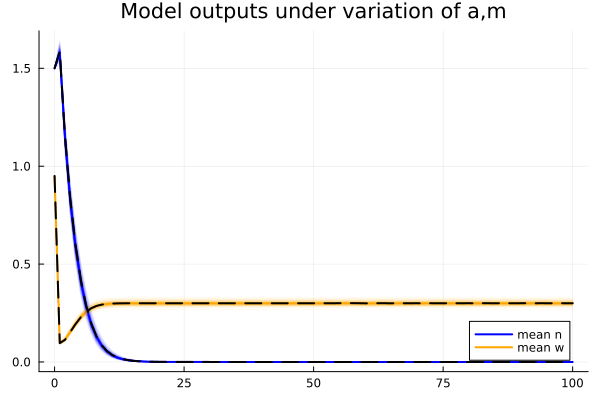

In [116]:
# compute sample trajectories
n_traj_sampled, w_traj_sampled = sample_am_traj(posterior, n)

# plot probabilistic solution trajectories
plot_prob_traj(times, n_traj_sampled, w_traj_sampled, data_true, "a,m")

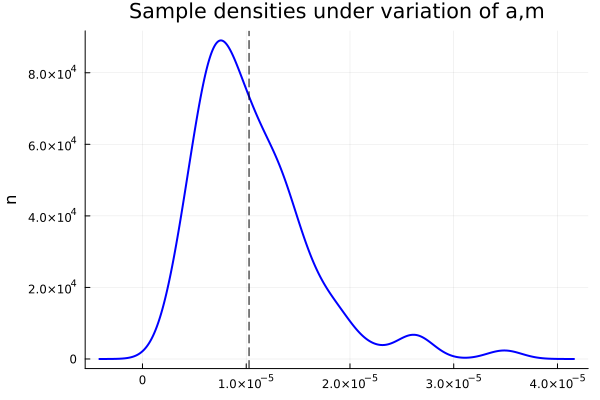

In [117]:
plot_sample_dens_t(t_pt_sample_dens, n_traj_sampled, n_t_true, "n")

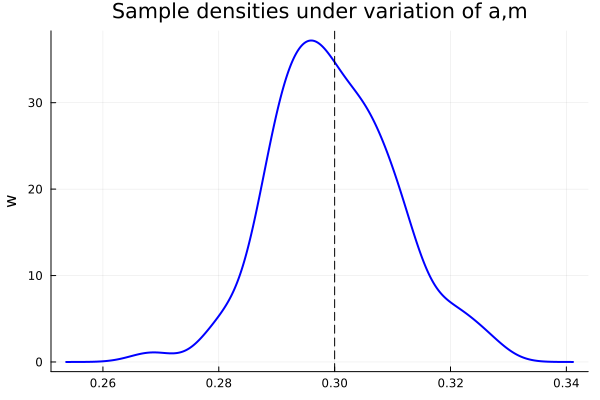

In [118]:
plot_sample_dens_t(t_pt_sample_dens, w_traj_sampled, w_t_true, "w")

#### noise = 0.1

For now: manually extract MLEs for a, m from inverse uq notebook

In [119]:
mle = [0.304974693418045, 0.4454823320707919]

2-element Vector{Float64}:
 0.304974693418045
 0.4454823320707919

Fisher inversion: Use inverse of Fisher Information Matrix as approximation of covariance matrix

In [120]:
cov = [0.00105569  0.00035361; 0.00035361  0.00294412]

2×2 Matrix{Float64}:
 0.00105569  0.00035361
 0.00035361  0.00294412

In [121]:
posterior = MvNormal(mle, cov)

FullNormal(
dim: 2
μ: [0.304974693418045, 0.4454823320707919]
Σ: [0.00105569 0.00035361; 0.00035361 0.00294412]
)


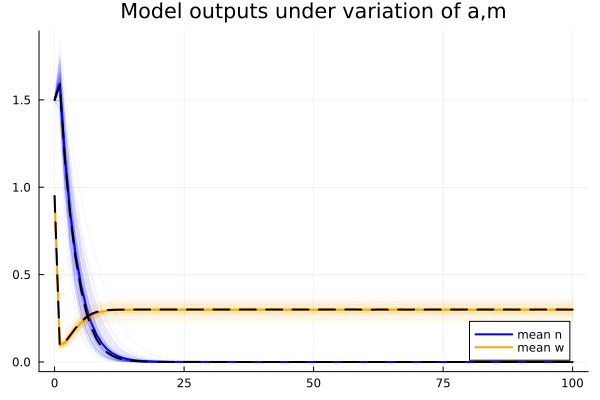

In [122]:
# compute sample trajectories
n_traj_sampled, w_traj_sampled = sample_am_traj(posterior, n)

# plot probabilistic solution trajectories
plot_prob_traj(times, n_traj_sampled, w_traj_sampled, data_true, "a,m")

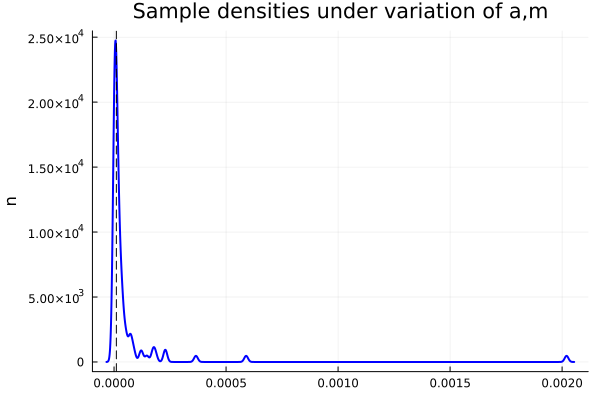

In [123]:
plot_sample_dens_t(t_pt_sample_dens, n_traj_sampled, n_t_true, "n")

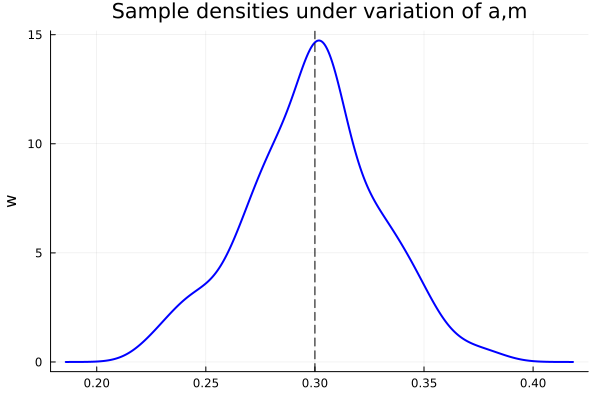

In [124]:
 plot_sample_dens_t(t_pt_sample_dens, w_traj_sampled, w_t_true, "w")

#### noise 0.5

In [125]:
mle = [0.3200212607414804, 0.5289705752648506]
cov = [0.00524214  0.0015298; 0.0015298   0.017724]
posterior = MvNormal(mle, cov)

FullNormal(
dim: 2
μ: [0.3200212607414804, 0.5289705752648506]
Σ: [0.00524214 0.0015298; 0.0015298 0.017724]
)


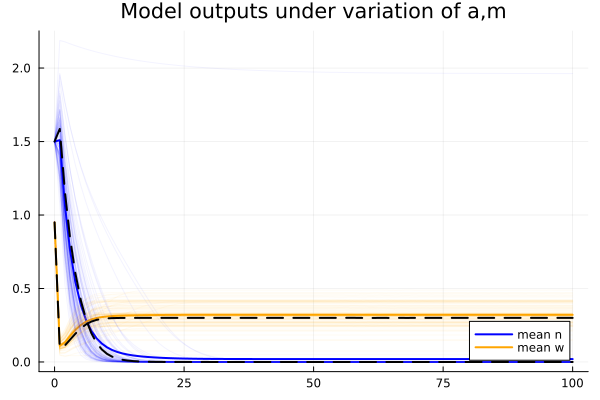

In [126]:
# compute sample trajectories
n_traj_sampled, w_traj_sampled = sample_am_traj(posterior, n)

# plot probabilistic solution trajectories
plot_prob_traj(times, n_traj_sampled, w_traj_sampled, data_true, "a,m")

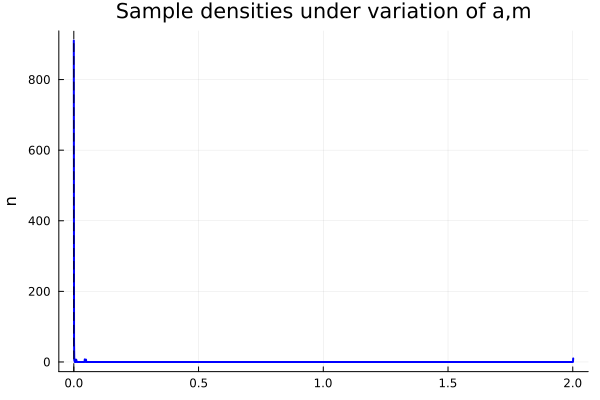

In [127]:
plot_sample_dens_t(t_pt_sample_dens, n_traj_sampled, n_t_true, "n")

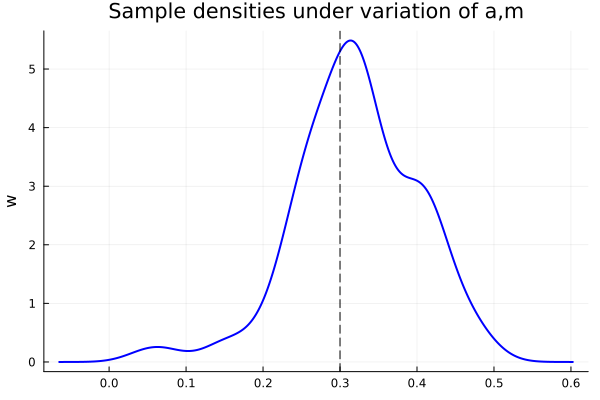

In [128]:
 plot_sample_dens_t(t_pt_sample_dens, w_traj_sampled, w_t_true, "w")

### MIDDLE

In [129]:
# create true data trajectories
w0 = 0.95
n0 = 1.5
a = 0.9
m = 0.45
M = 100
noise = 0.0

hprm = Src.Hyperprm(w0,n0,a,m,M,noise)
data_true = Src.sol_klausmeier(hprm, t_fixed=t_fixed, t_end=t_end) # non-noisy data
times = data_true[!,"time"]

# true values at t_pt_sample_dens
n_t_true, w_t_true = data_true[!,"n"][t_pt_sample_dens], data_true[!,"w"][t_pt_sample_dens];

#### noise 0.01

In [130]:
mle = [0.8997987772298199, 0.44979755966016816]
cov = [0.000474274  0.000233066; 0.000233066  0.000114651]
posterior = MvNormal(mle, cov)

FullNormal(
dim: 2
μ: [0.8997987772298199, 0.44979755966016816]
Σ: [0.000474274 0.000233066; 0.000233066 0.000114651]
)


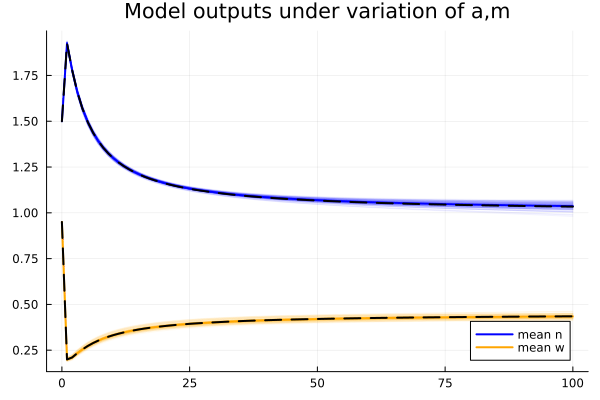

In [131]:
# compute sample trajectories
n_traj_sampled, w_traj_sampled = sample_am_traj(posterior, n)

# plot probabilistic solution trajectories
plot_prob_traj(times, n_traj_sampled, w_traj_sampled, data_true, "a,m")

#### noise 0.1

In [132]:
mle = [0.9238311062314665, 0.4617191527381877]
cov = [0.00478534  0.00235295; 0.00235295  0.0011581]
posterior = MvNormal(mle, cov)

FullNormal(
dim: 2
μ: [0.9238311062314665, 0.4617191527381877]
Σ: [0.00478534 0.00235295; 0.00235295 0.0011581]
)


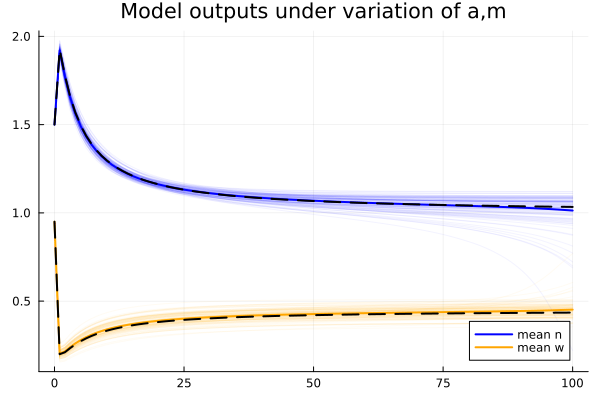

In [133]:
# compute sample trajectories
n_traj_sampled, w_traj_sampled = sample_am_traj(posterior, n)

# plot probabilistic solution trajectories
plot_prob_traj(times, n_traj_sampled, w_traj_sampled, data_true, "a,m")

#### noise 0.5

In [134]:
mle = [0.7703321103101506, 0.38254686608336913]
cov = [0.0257831  0.0124982; 0.0124982  0.00607234]
posterior = MvNormal(mle, cov)

FullNormal(
dim: 2
μ: [0.7703321103101506, 0.38254686608336913]
Σ: [0.0257831 0.0124982; 0.0124982 0.00607234]
)


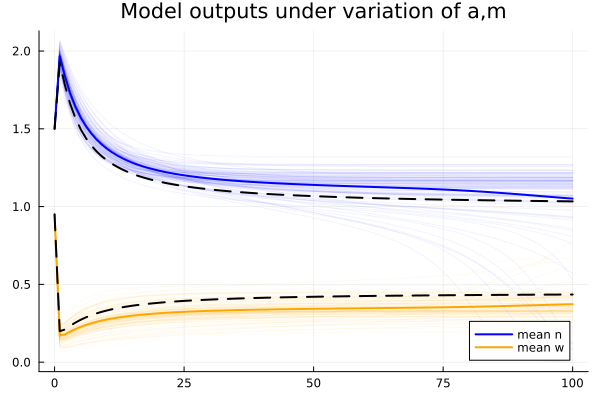

In [135]:
# compute sample trajectories
n_traj_sampled, w_traj_sampled = sample_am_traj(posterior, n)

# plot probabilistic solution trajectories
plot_prob_traj(times, n_traj_sampled, w_traj_sampled, data_true, "a,m")

### RIGHT

In [136]:
# create true data trajectories
w0 = 0.95
n0 = 1.5
a = 1.5
m = 0.45
M = 100
noise = 0.0

hprm = Src.Hyperprm(w0,n0,a,m,M,noise)
data_true = Src.sol_klausmeier(hprm, t_fixed=t_fixed, t_end=t_end) # non-noisy data
times = data_true[!,"time"]

# true values at t_pt_sample_dens
n_t_true, w_t_true = data_true[!,"n"][t_pt_sample_dens], data_true[!,"w"][t_pt_sample_dens];

#### noise 0.01

In [137]:
mle = [1.4913881780463378, 0.4472661036423614]
cov = [0.00825544  0.00247872; 0.00247872  0.000745729]
posterior = MvNormal(mle, cov)

FullNormal(
dim: 2
μ: [1.4913881780463378, 0.4472661036423614]
Σ: [0.00825544 0.00247872; 0.00247872 0.000745729]
)


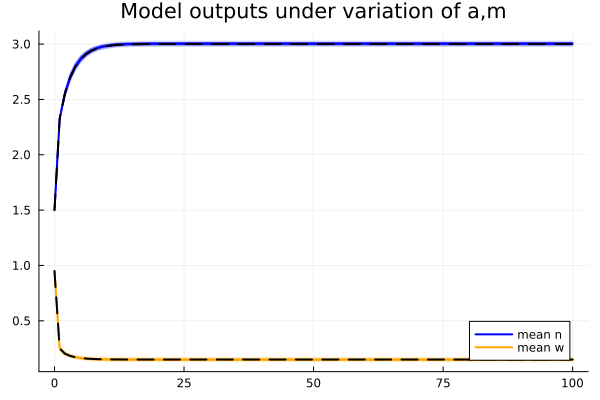

In [138]:
# compute sample trajectories
n_traj_sampled, w_traj_sampled = sample_am_traj(posterior, n)

# plot probabilistic solution trajectories
plot_prob_traj(times, n_traj_sampled, w_traj_sampled, data_true, "a,m")

#### noise 0.1

In [139]:
mle = [1.5187783935416252, 0.4567077569943699]
cov = [0.0794924 0.0239252; 0.0239252 0.00721644]
posterior = MvNormal(mle, cov)

FullNormal(
dim: 2
μ: [1.5187783935416252, 0.4567077569943699]
Σ: [0.0794924 0.0239252; 0.0239252 0.00721644]
)


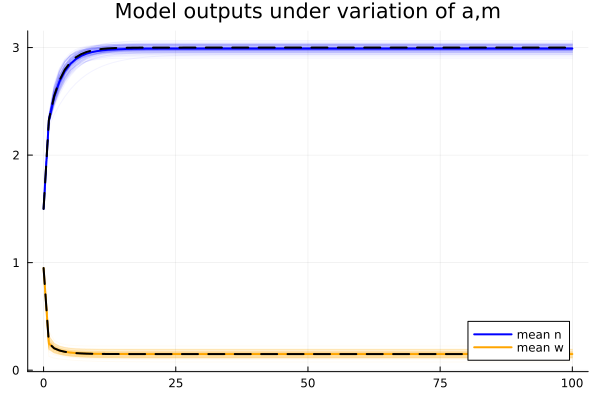

In [140]:
# compute sample trajectories
n_traj_sampled, w_traj_sampled = sample_am_traj(posterior, n)

# plot probabilistic solution trajectories
plot_prob_traj(times, n_traj_sampled, w_traj_sampled, data_true, "a,m")

#### noise 0.5

In [141]:
mle = [1.8755873546199178, 0.5619295097088033]
cov = [0.385396  0.115215; 0.115215  0.0345592]
posterior = MvNormal(mle, cov)

FullNormal(
dim: 2
μ: [1.8755873546199178, 0.5619295097088033]
Σ: [0.385396 0.115215; 0.115215 0.0345592]
)


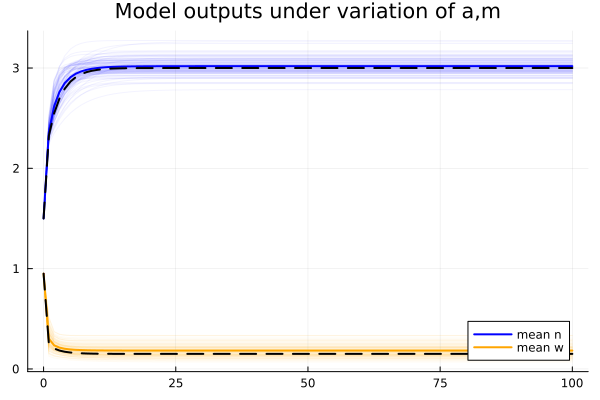

In [142]:
# compute sample trajectories
n_traj_sampled, w_traj_sampled = sample_am_traj(posterior, n)

# plot probabilistic solution trajectories
plot_prob_traj(times, n_traj_sampled, w_traj_sampled, data_true, "a,m")